# Notebook 6: Classification
<br>
In this notebook, we use some classification methods to predict if a ride was performed with or without a passenger.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from my_utils import *
import pickle

C:\Users\giuli\Anaconda3\envs\skmob\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Outline

1. [Data loading](#dataloading)
2. [Data preparation](#data_prep)
3. [Classification](#classification)<br>
    3.1 [Dummy classifiers](#dummy)<br>
    3.2 [Decision tree](#dtree)<br>
    3.3 [Random forest](#rforest)<br>
    3.4 [k-nearest neighbors](#knn)<br>
    3.5 [Artifical neural network](#ann)<br>
4. [Final model selection and model assessment](#conc)


<a id="dataloading"></a>
## 1. Data loading
Load the clean ride dataset (computed in the jupyter notebook `2_data_pre_processing.ipynb`)

In [2]:
dataset_rides_path = '../data/datasets/tdf_rides_clean.zip'

#load the clean rides dataset
tdf_rides = pd.read_csv(dataset_rides_path, sep='\t', 
                        parse_dates=['start_time','end_time'], compression='zip')

In [3]:
tdf_rides[:3]

,uid,traj_id,occupancy,start_lat,start_lng,start_time,end_lat,end_lng,end_time,dist_start_end,cumulative_distance,avg_speed_kmh,dt_seconds,start_hour,day
0,abboip,0,0,37.75149,-122.39447,2008-05-17 07:12:10,37.749775,-122.397165,2008-05-17 07:50:44,0.304153,0.321501,5.056473,2314,7,5
1,abboip,1,1,37.74896,-122.40619,2008-05-17 07:52:11,37.755660,-122.414395,2008-05-17 07:55:58,1.037017,1.456743,22.897152,227,7,5
2,abboip,2,0,37.76172,-122.41496,2008-05-17 07:57:10,37.750530,-122.420860,2008-05-17 08:10:22,1.348054,2.826816,16.491674,792,7,5


<a id="data_prep"></a>
## 2. Data preparation

I will use a Cross Validation (CV) + test schema (80% for CV and 20% for testing)

The CV is used for the **MODEL SELECTION** phase, while the test set is used for **MODEL ASSESSMENT**.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" style="width:500px">

In [4]:
#create X and y which contains the features and the output variable, respectively

features = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'dist_start_end', 
                'cumulative_distance', 'avg_speed_kmh', 'dt_seconds', 'start_hour', 'day']

target = 'occupancy'

if target in features:
    print("The target variable must not be included in the features.")

X = tdf_rides[features]
y = tdf_rides[target]

Train and test partitioning

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(620299, 10) (620299,)
(155075, 10) (155075,)


In [7]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([267835, 352464], dtype=int64))

## 3. Classification 
#### Task: predict whether a ride was performed with or without a passenger. <br>
Given the starting position, destination, distance start-end, cumulative distance, avg.speed km/h, trip duration, start hour, and day of the week predict the binary variable occupancy. <br>

- target: occupancy (binary classification)
- Methods: Decision Tree, Random Forest, K-nn, ANN
- Baselines: Dummy classifiers

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree

<a id="dummy"></a>
### 3.1 Dummy Classifiers

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
#always 0
dummy_0 = DummyClassifier(strategy="constant", constant=0)
dummy_0.fit(X_train,y_train)

#always 1
dummy_1 = DummyClassifier(strategy="constant", constant=1)
dummy_1.fit(X_train,y_train)

# uniform at random
dummy_uniform = DummyClassifier(strategy="uniform", random_state=5)
dummy_uniform.fit(X_train,y_train)

# most frequent
dummy_most_freq = DummyClassifier(strategy="most_frequent")
dummy_most_freq.fit(X_train,y_train)

dummies = {'always_0':dummy_0,'always_1':dummy_1,
           'random':dummy_uniform,'most_freq':dummy_most_freq}

for k in dummies.keys():
    clf = dummies[k]
    score = cross_val_score(clf, X, y, cv=5)
    print(k+": "+str(score.mean())[:6]+" (std. "+str(score.std())[:6]+")")

always_0: 0.4317 (std. 1.4656)
always_1: 0.5682 (std. 1.4656)
random: 0.4997 (std. 0.0010)
most_freq: 0.5682 (std. 1.4656)


As expected a dummy classifier accuracy is pretty low, given the nature of the problem.

<a id="dtree"></a>
### 3.2 Decision Tree

Model selection phase

In [11]:
params_list = {'max_depth': [None] + list(np.arange(2, 20, 2)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy']
             }

The following is a time-consuming cell ($\approx$ 51 min).

If the file `../data/results/results_cv_decision_tree.zip` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [12]:
%%time

run_time_consuming_ops = False

if run_time_consuming_ops:

    clf = DecisionTreeClassifier()

    grid_search = GridSearchCV(clf, param_grid=params_list, cv=5, verbose=4, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    #save the results (no need to compress)
    df_cv_decision_tree = pd.DataFrame(grid_search.cv_results_)
    df_cv_decision_tree.to_csv("../data/results/results_cv_decision_tree.csv", 
                               sep='\t', index=False)
    print("Time consuming operations performed!")
    
else:
    df_cv_decision_tree = pd.read_csv("../data/results/results_cv_decision_tree.csv", sep='\t')
    print("Time-saving file loaded!")

Time-saving file loaded!
Wall time: 10.1 ms


Look at the best 3 models (wrt validation score) and then select the best decision tree (model selection).

In [13]:
report_results_cv(df_cv_decision_tree, n_top=3)

Model with rank: 1
Mean validation score: 0.8062 (std: 0.0010)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 50}

Model with rank: 2
Mean validation score: 0.8062 (std: 0.0011)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 100}

Model with rank: 3
Mean validation score: 0.8062 (std: 0.0010)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 5}



The best Decision Tree model has the following parameters:

Validation score = 0.8062

max_depth: None <br>
criterion: entropy <br>
min_samples_leaf: 50 <br>
min_samples_split: 50 <br>

Train the best decision tree on the whole training set

In [14]:
best_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, 
                                 min_samples_leaf=50, min_samples_split=50)

best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50,
                       min_samples_split=50)

Train accuracy

In [15]:
# compute the predictions on the train set
y_pred_train = best_dt.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_train))
print('Train F1-score %s' % f1_score(y_train, y_pred_train, average=None))
print()
print(classification_report(y_train, y_pred_train))

Train Accuracy 0.8338140154989772
Train F1-score [0.80744553 0.85383052]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81    267835
           1       0.85      0.85      0.85    352464

    accuracy                           0.83    620299
   macro avg       0.83      0.83      0.83    620299
weighted avg       0.83      0.83      0.83    620299



### Model assessment

Test accuracy (Model assessment)

In [16]:
# compute the predictions on the test set
y_pred_test = best_dt.predict(X_test)

print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('Test F1-score %s' % f1_score(y_test, y_pred_test, average=None))
print()
print(classification_report(y_test, y_pred_test))

Test Accuracy 0.8084797678542641
Test F1-score [0.77802691 0.83158492]

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     66959
           1       0.83      0.83      0.83     88116

    accuracy                           0.81    155075
   macro avg       0.80      0.80      0.80    155075
weighted avg       0.81      0.81      0.81    155075



### feature importance

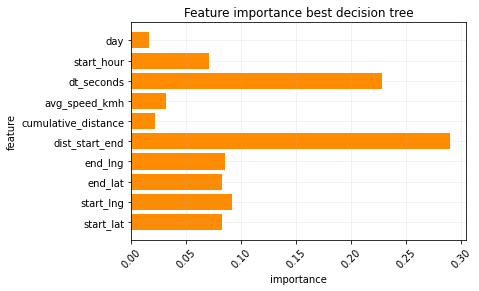

In [17]:
plt.barh(features, best_dt.feature_importances_, color='darkorange')
plt.xticks(rotation=45)
plt.title("Feature importance best decision tree")
plt.ylabel("feature")
plt.xlabel("importance")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/feature_importance_dt.pdf')

<a id="rforest"></a>
### 3.3 Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
params_list_rf = {'n_estimators':[51,75,101,125],
              'max_depth': [None, 18],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 5]
             }

The following is a time-consuming cell ($\approx$ 5 min).

If the file `../data/results/results_cv_random_forest.zip` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [20]:
%%time

run_time_consuming_ops = False

if run_time_consuming_ops:

    grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=params_list_rf, cv=5, verbose=4, n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)

    #save the results (no need to compress)
    df_cv_random_forest = pd.DataFrame(grid_search_rf.cv_results_)
    df_cv_random_forest.to_csv("../data/results/results_cv_random_forest.csv", 
                               sep='\t', index=False)
else:
    df_cv_random_forest = pd.read_csv("../data/results/results_cv_random_forest.csv", sep='\t')
    print("Time-saving file loaded!")

Time-saving file loaded!
Wall time: 0 ns


Look at the best 3 models (wrt validation score) and then select the best random forest (model selection).

In [21]:
report_results_cv(df_cv_random_forest, n_top=3)

Model with rank: 1
Mean validation score: 0.8384 (std: 0.0008)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 101}

Model with rank: 2
Mean validation score: 0.8383 (std: 0.0005)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}

Model with rank: 3
Mean validation score: 0.8381 (std: 0.0007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 125}



The best Random Forest model has the following parameters:

Validation score = 0.8384

max_depth: None <br>
n_estimators: 101 <br>
min_samples_leaf: 1 <br>
min_samples_split: 5 <br>

Train on the whole training set

In [22]:
%%time
best_rf = RandomForestClassifier(max_depth=None, n_estimators=101, min_samples_leaf=1,
                                min_samples_split=5)

best_rf.fit(X_train, y_train)

Wall time: 6min 14s


RandomForestClassifier(min_samples_split=5, n_estimators=101)

Train accuracy

In [23]:
%%time
# compute the predictions on the train set
y_pred_train_rf = best_rf.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_train_rf))
print('Train F1-score %s' % f1_score(y_train, y_pred_train_rf, average=None))
print()
print(classification_report(y_train, y_pred_train_rf))

Train Accuracy 0.9967805848469851
Train F1-score [0.99626915 0.99716871]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267835
           1       1.00      1.00      1.00    352464

    accuracy                           1.00    620299
   macro avg       1.00      1.00      1.00    620299
weighted avg       1.00      1.00      1.00    620299

Wall time: 34.5 s


### Model assessment

Test accuracy (Model assessment)

In [24]:
%%time
# compute the predictions on the test set
y_pred_test_rf = best_rf.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test_rf))
print('Test F1-score %s' % f1_score(y_test, y_pred_test_rf, average=None))
print()
print(classification_report(y_test, y_pred_test_rf))

Test Accuracy 0.8398581331613735
Test F1-score [0.81321078 0.85985169]

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     66959
           1       0.86      0.86      0.86     88116

    accuracy                           0.84    155075
   macro avg       0.84      0.84      0.84    155075
weighted avg       0.84      0.84      0.84    155075

Wall time: 8.84 s


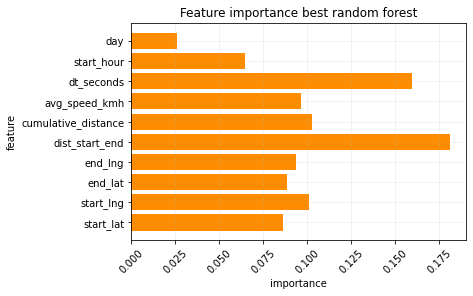

In [25]:
plt.barh(features, best_rf.feature_importances_, color='darkorange')
plt.xticks(rotation=45)
plt.title("Feature importance best random forest")
plt.ylabel("feature")
plt.xlabel("importance")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/feature_importance_rf.pdf')

<a id="knn"></a>
### 3.4 K-Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [27]:
# apply a scaler when dealing with distance-based algorithms

ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [28]:
params_list_knn = {'n_neighbors':[1,3,5,7,11,15,19,21,23,25,31],
                  'weights': ['uniform','distance'],
                  'metric': ['euclidean','manhattan'],
                 }

The following is a time-consuming cell ($\approx$ 33 min).

If the file `../data/results/results_cv_knn.zip` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [29]:
%%time

run_time_consuming_ops = False

if run_time_consuming_ops:

    grid_search_knn = GridSearchCV(KNeighborsClassifier(), 
                                   param_grid=params_list_knn, cv=5, verbose=4, n_jobs=-1)

    grid_search_knn.fit(X_train_ss, y_train)

    #save the results (no need to compress)
    df_cv_knn = pd.DataFrame(grid_search_knn.cv_results_)
    df_cv_knn.to_csv("../data/results/results_cv_knn.csv", sep='\t', index=False)
    
else:
    df_cv_knn = pd.read_csv("../data/results/results_cv_knn.csv", sep='\t')
    print("Time-saving file loaded!")  

Time-saving file loaded!
Wall time: 0 ns


Look at the best 3 models (wrt validation score) and then select the best random forest (model selection).

In [30]:
report_results_cv(df_cv_knn, n_top=3)

Model with rank: 1
Mean validation score: 0.8215 (std: 0.0005)
Parameters: {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.8215 (std: 0.0003)
Parameters: {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.8214 (std: 0.0003)
Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}



The best K-nn model has the following parameters:

Validation score = 0.8215

n_neighbors: 23 <br>
metric: manhattan <br>
weights: distance <br>

Train on the whole training set

In [31]:
%%time
best_knn = KNeighborsClassifier(metric='manhattan', 
                                n_neighbors=23, 
                                weights='distance')

best_knn.fit(X_train_ss, y_train)

Wall time: 4.71 s


KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')

Train accuracy

The following is a time-consuming cell ($\approx$ 10 min).

If the file `../data/results/y_pred_train_knn.pickle` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [32]:
%%time
# compute the predictions on the train set

run_time_consuming_ops = False

if run_time_consuming_ops:

    y_pred_train_knn = best_knn.predict(X_train_ss)
    
    # save into a pickle file
    with open('../data/results/y_pred_train_knn.pickle', 'wb') as handle:
        pickle.dump(y_pred_train_knn, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    # load the pickle
    with open('../data/results/y_pred_train_knn.pickle', 'rb') as handle:
        y_pred_train_knn = pickle.load(handle)
    print("Time-saving file loaded!")

Time-saving file loaded!
Wall time: 0 ns


In [33]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_train_knn))
print('Train F1-score %s' % f1_score(y_train, y_pred_train_knn, average=None))
print()
print(classification_report(y_train, y_pred_train_knn))

Train Accuracy 1.0
Train F1-score [1. 1.]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267835
           1       1.00      1.00      1.00    352464

    accuracy                           1.00    620299
   macro avg       1.00      1.00      1.00    620299
weighted avg       1.00      1.00      1.00    620299



### Model assessment

Test accuracy (Risk estimation)

The following is a time-consuming cell ($\approx$ 3 min).

If the file `../data/results/y_pred_test_knn.pickle` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [34]:
%%time
# compute the predictions on the test set

run_time_consuming_ops = False

if run_time_consuming_ops:
    
    y_pred_test_knn = best_knn.predict(X_test_ss)
    # save into a pickle file
    with open('../data/results/y_pred_test_knn.pickle', 'wb') as handle:
        pickle.dump(y_pred_test_knn, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    # load the pickle
    with open('../data/results/y_pred_test_knn.pickle', 'rb') as handle:
        y_pred_test_knn = pickle.load(handle)
    print("Time-saving file loaded!")

Time-saving file loaded!
Wall time: 0 ns


In [35]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test_knn))
print('Test F1-score %s' % f1_score(y_test, y_pred_test_knn, average=None))
print()
print(classification_report(y_test, y_pred_test_knn))

Test Accuracy 0.8225052394002902
Test F1-score [0.79187932 0.8452739 ]

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     66959
           1       0.84      0.85      0.85     88116

    accuracy                           0.82    155075
   macro avg       0.82      0.82      0.82    155075
weighted avg       0.82      0.82      0.82    155075



<a id="ann"></a>
### Artificial Neural Network

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
# apply a scaler when dealing with distance-based algorithms

ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

I performed different cross-validations varying only the hidden layer sizes.
I didn't perform a grid search cross-validation due to the high training time required by the network.<br><br>
The following table summarizes the validation scores obtained:

|     hidden_layer_sizes     | Validation score |
|:-------------:|:-----------:|
| (60, 60, 60) |   0.8364   | 
| (70, 70, 70) |   0.8372    |     
| (90, 90, 90) |   0.8374   |     
| (100,100,100)|  0.8365    |
|(30, 60, 60, 30)|0.8350|
|(90, 50, 50, 90)|0.8364|

The following is a time-consuming cell ($\approx$ 3 min).

If the file `../data/models/best_nn.pickle` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [38]:
%%time
### train on the whole training set

run_time_consuming_ops = False

if run_time_consuming_ops:

    best_nn = MLPClassifier(activation='relu', learning_rate_init = 0.0025, batch_size = 256, 
                            hidden_layer_sizes = (90, 90, 90), learning_rate = 'adaptive', 
                            max_iter = 2000, solver = 'adam', random_state = 42)

    best_nn.fit(X_train_ss, y_train)
    
    # save the trained netwoek on a pickle file
    with open('../data/models/best_nn.pickle', 'wb') as handle:
        pickle.dump(best_nn, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # restore the trained best_nn

    with open('../data/models/best_nn.pickle', 'rb') as handle:
        best_nn = pickle.load(handle)
    print("Time-saving file loaded!")

Time-saving file loaded!
Wall time: 0 ns


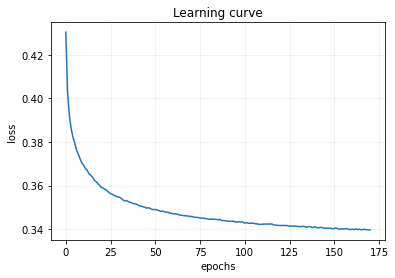

In [39]:
#check the loss curve of the trained NN

plt.plot(best_nn.loss_curve_)
plt.title("Learning curve")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(alpha=0.2)
plt.savefig('../data/plots/learning_curve_best_nn.pdf')

Train accuracy

In [40]:
y_pred_train_ann = best_nn.predict(X_train_ss)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_train_ann))
print('Train F1-score %s' % f1_score(y_train, y_pred_train_ann, average=None))

Train Accuracy 0.8526855597058838
Train F1-score [0.82768076 0.87135317]


### Model assessment

Test accuracy (Risk estimation)

In [41]:
y_pred_test_ann = best_nn.predict(X_test_ss)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test_ann))
print('Test F1-score %s' % f1_score(y_test, y_pred_test_ann, average=None))

Test Accuracy 0.8389102047396421
Test F1-score [0.8113944  0.85941958]


<a id="conc"></a>
## 4. Final model selection and model assessment

The following table summarizes the accuracy obtained from the classification models with respect to the training set, cross-validation, and test set.<br><br>
We should select the model considering ONLY the **Validation Score** (model selection phase), and the model with the highest Validation score is the Random Forest (0.8384) with a model assessment score of 0.8392.<br><br>

Futhermore, the results show that there is no overfitting for the models.<br><br>

|     Model     | Train Score | Validation Score | Risk assessment |   |
|:-------------:|:-----------:|:----------------:|:---------------:|---|
| Decision tree |   0.8338    |      0.8062      |    0.8086  |   |
| Random forest |   0.9965   |     0.8384      |     0.8392      |   |
| K-nn          |    1.0      |     0.8215     |      0.8225   |   |
|  ANN         |  0.8527        |     0.8374            |     0.8389           |   |